# NMR-EsPy Example: J-resolved estimation
In this example, I will go through some of the most useful features of the `Estimator2DJ` class for the consideration of data deived from J-resolved (2DJ) experiments. We will be using a simulated ¹H 2DJ spectrum of sucrose for this example. The data will simulated using [Spinach](https://spindynamics.org/wiki/index.php?title=Main_Page) if you have it. If you don't, you can use my far less impressive package [nmr_sims](https://foroozandehgroup.github.io/nmr_sims/content/) instead, which is automatically installed with `pip install nmrespy`.

## Pre-requisites
We will start by importing the pre-specified isotropic chemical shifts and scalar couplings, contained in the files `sucrose_shifts.pkl` and `sucrose_couplings.pkl`, respectively.

Note that if you want to specify your own spin systems, `shifts` and `couplings` need be of the following forms:

* `shifts`: A list of floats, with each value specifying the isotropic chemical shift in ppm.
* `couplings` A list of 3-element tuples, with each tuple of the form `(i1: int, i2: int, x: float)`. `i1` and       `i2` are the spins involved in the coupling (counting starts at 1...), and `x` is their scalar coupling in Hz.

In [1]:
import pickle
with open("sucrose_shifts.pkl", "rb") as fh:
    sucrose_shifts = pickle.load(fh)
with open("sucrose_couplings.pkl", "rb") as fh:
    sucrose_couplings = pickle.load(fh)

print("----- SHIFTS -----")
print("\n".join([f"{i:<5}{shift:.3f}ppm" for i, shift in enumerate(sucrose_shifts, start=1)]))
print("\n----- COUPLINGS -----")
print("\n".join([f"{i1:<3}- {i2:<5}{x:.3f}Hz" for i1, i2, x in sucrose_couplings]))

----- SHIFTS -----
1    6.005ppm
2    3.510ppm
3    3.934ppm
4    3.423ppm
5    4.554ppm
6    3.891ppm
7    4.287ppm
8    3.332ppm
9    1.908ppm
10   1.555ppm
11   0.644ppm
12   4.042ppm
13   4.517ppm
14   3.889ppm
15   4.635ppm
16   4.160ppm
17   4.021ppm
18   4.408ppm
19   0.311ppm
20   1.334ppm
21   0.893ppm
22   0.150ppm

----- COUPLINGS -----
1  - 2    2.285Hz
2  - 3    4.657Hz
2  - 8    4.828Hz
3  - 4    4.326Hz
4  - 5    4.851Hz
5  - 6    5.440Hz
5  - 7    2.288Hz
6  - 7    -6.210Hz
7  - 11   7.256Hz
12 - 13   -4.005Hz
12 - 19   1.460Hz
14 - 15   4.253Hz
15 - 16   4.448Hz
15 - 21   3.221Hz
16 - 18   4.733Hz
17 - 18   -4.182Hz
18 - 22   1.350Hz


## Setting up the estimator
There are a number of ways to instantiate an instance of `Estimator2DJ`. Two classmethods exist to create estimators from Spinach- and nmr_sims-simulated data, called `new_spinach` and `new_nmrsims`, respectively. We will assume a 300MHz magnet, set the transmitter offset at 1000Hz, the sweep widths in F1 and F2 as 40Hz and 2200Hz, and the number of samples in T1 and T2 as 64 and 4096.

**N.B.** the `MATLAB_AVAILABLE` flag will be `True` if you have the [MATLAB Engine for Python](https://uk.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html) accessible to your current Python executable. NMR-EsPy does not check that you have also installed and configured Spinach correctly. You will need to do this in order to successfully run `new_spinach`

In [2]:
import nmrespy as ne

# Set this to False if you have MATLAB and the Matlab engine for Python installed,
# but have not installed Spinach!
i_have_installed_spinach = True

args = (
    sucrose_shifts,  # chemical shifts
    (64, 4096),      # pts
    (40., 2200.),    # sw
    1000.,           # offset
)
kwargs = {
    "couplings": sucrose_couplings,  # by default (None), no couplings are applied.
    "field": 300.,
    "field_unit": "MHz",
}

if ne.MATLAB_AVAILABLE and i_have_installed_spinach:
    estimator = ne.Estimator2DJ.new_spinach(*args, **kwargs)
    
else:
    estimator = ne.Estimator2DJ.new_nmrsims(*args, **kwargs)

**Feel free to ignore this bit...** 

*For Simon: TODO* Do this automatically when constructing the data.

In [3]:
estimator._data = ne.sig.exp_apodisation(estimator._data, 5.)

## Running the estimation routine

We will now estimate the entire signal by generating filtered "sub-signals" in the direct dimension, and estimate each of these in turn. For the best results, it is necessary to specifiy region bounds that do not coincide with peaks in the direct-dimension spectrum, as this will lead to sub-signals which do not satify the underlying assumptions about the signal's structure which NMR-EsPy relies on.

In [4]:
regions = (                                                                             
    (6.08, 5.91),                                                                       
    (4.72, 4.46),                                                                       
    (4.46, 4.22),                                                                       
    (4.22, 4.1),                                                                        
    (4.09, 3.98),                                                                       
    (3.98, 3.83),                                                                       
    (3.58, 3.28),                                                                       
    (2.08, 1.16),                                                                       
    (1.05, 0.0),                                                                        
)      
n_regions = len(regions)
common_kwargs = {
    "noise_region": (5.5, 5.33),
    "region_unit": "ppm",             
    "max_iterations": 40,
    "nlp_trim": 512,
    "fprint": False,                          
    "phase_variance": True,
}

for i, region in enumerate(regions, start=1):
    print(f"---> {i} / {n_regions}: {region[0]} - {region[1]}ppm")
    kwargs = {**{"region": region}, **common_kwargs}
    estimator.estimate(**kwargs)                                                       

---> 1 / 9: 6.08 - 5.91ppm
---> 2 / 9: 4.72 - 4.46ppm
---> 3 / 9: 4.46 - 4.22ppm
---> 4 / 9: 4.22 - 4.1ppm
---> 5 / 9: 4.09 - 3.98ppm
---> 6 / 9: 3.98 - 3.83ppm
---> 7 / 9: 3.58 - 3.28ppm
---> 8 / 9: 2.08 - 1.16ppm
---> 9 / 9: 1.05 - 0.0ppm


## Predicting multiplets and removing spurious oscillators

With the estimation complete, it is useful to predict which oscillators correspond to particular multiplets, and if the are any oscillators which are spurious in nature. In a 2DJ experiment, we expect peaks corresponding to a particular multiplet to lie along a line at a 45° angle to the F1 and F2 axes. Equivalently, we expect the indirect and direct dimension frequencies $f_{1,m}$ and $f_{2,m}$ for each peak in a multiplet to satisfy $f_{2,m} - f_{1,m} = f_{\mathrm{c}}$, where $f_{\mathrm{c}}$
is the central frequency of the multiplet. Therefore, we expect $f_{2,m} - f_{1,m}$ for all peaks in a multiplet to be the same, withing a certain threshold\*. With this in mind, it is possible to assign multiplets to the estimation result.

Assigning multiplets provides a means of determining which oscillators are probably spurious. If there are any oscillators which are not part of a multiplet (i.e. they are assigned as a singlet by the multiplet prediction),
and which do not have an indirect dimension frequency close to 0Hz, the implication is these oscillators are infeasible, and hence should be removed.

To remove any oscillators like this, you can use the `remove_spurious_oscillators` method.

\*One sensible threshold is half the spectral resolution of the less-resolved dimension, which is pretty much always the indirect dimension, so the threshold can be set to $N_1  / 2 f_{\mathrm{sw}, 1}$

In [5]:
estimator.remove_spurious_oscillators(
    max_iterations=30,
    phase_variance=True,
    nlp_trim=512,
)

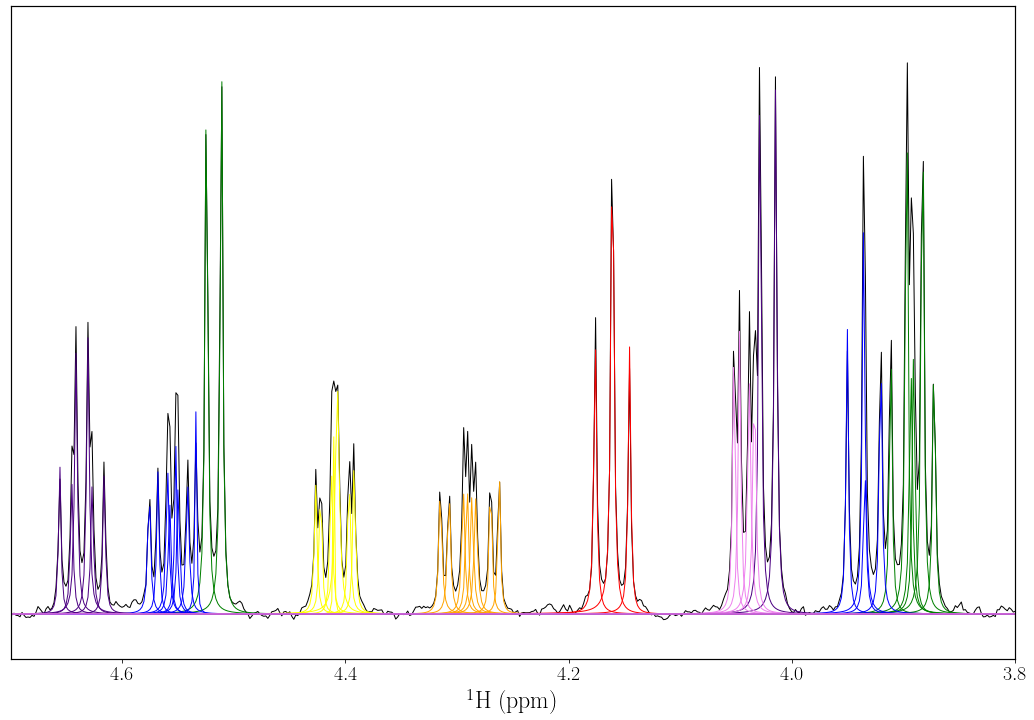

In [8]:
%matplotlib inline
fig = estimator.plot_multiplets(shifts_unit="ppm")

# You could simply save or show the figure at this point
# I'm just doing some hacking below to make the figure look nicer in the notebook
ax = fig.get_axes()[0]
ax.set_xlim(4.7, 3.8)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_xlabel(ax.get_xlabel(), fontdict={"fontsize": 24})
prev_ylim = ax.get_ylim()
ax.set_ylim(prev_ylim[0], 0.55 * prev_ylim[1])

fig.set_size_inches(*[3 * x for x in fig.get_size_inches()])